### Install Libraries

In [143]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn scipy joblib

### Import Libraries

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

import joblib
import os

### Load and Explore Data

In [145]:
def load_data(file_path='/content/Crop_recommendation.csv'):
    df = pd.read_csv(file_path)
    print("First few rows:")
    print(df.head())
    print("\nDataset Info:")
    print(df.info())
    print("\nMissing Values:", df.isnull().sum())
    return df

data = load_data()

First few rows:
    N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory 

### Exploratory Data Analysis (EDA)

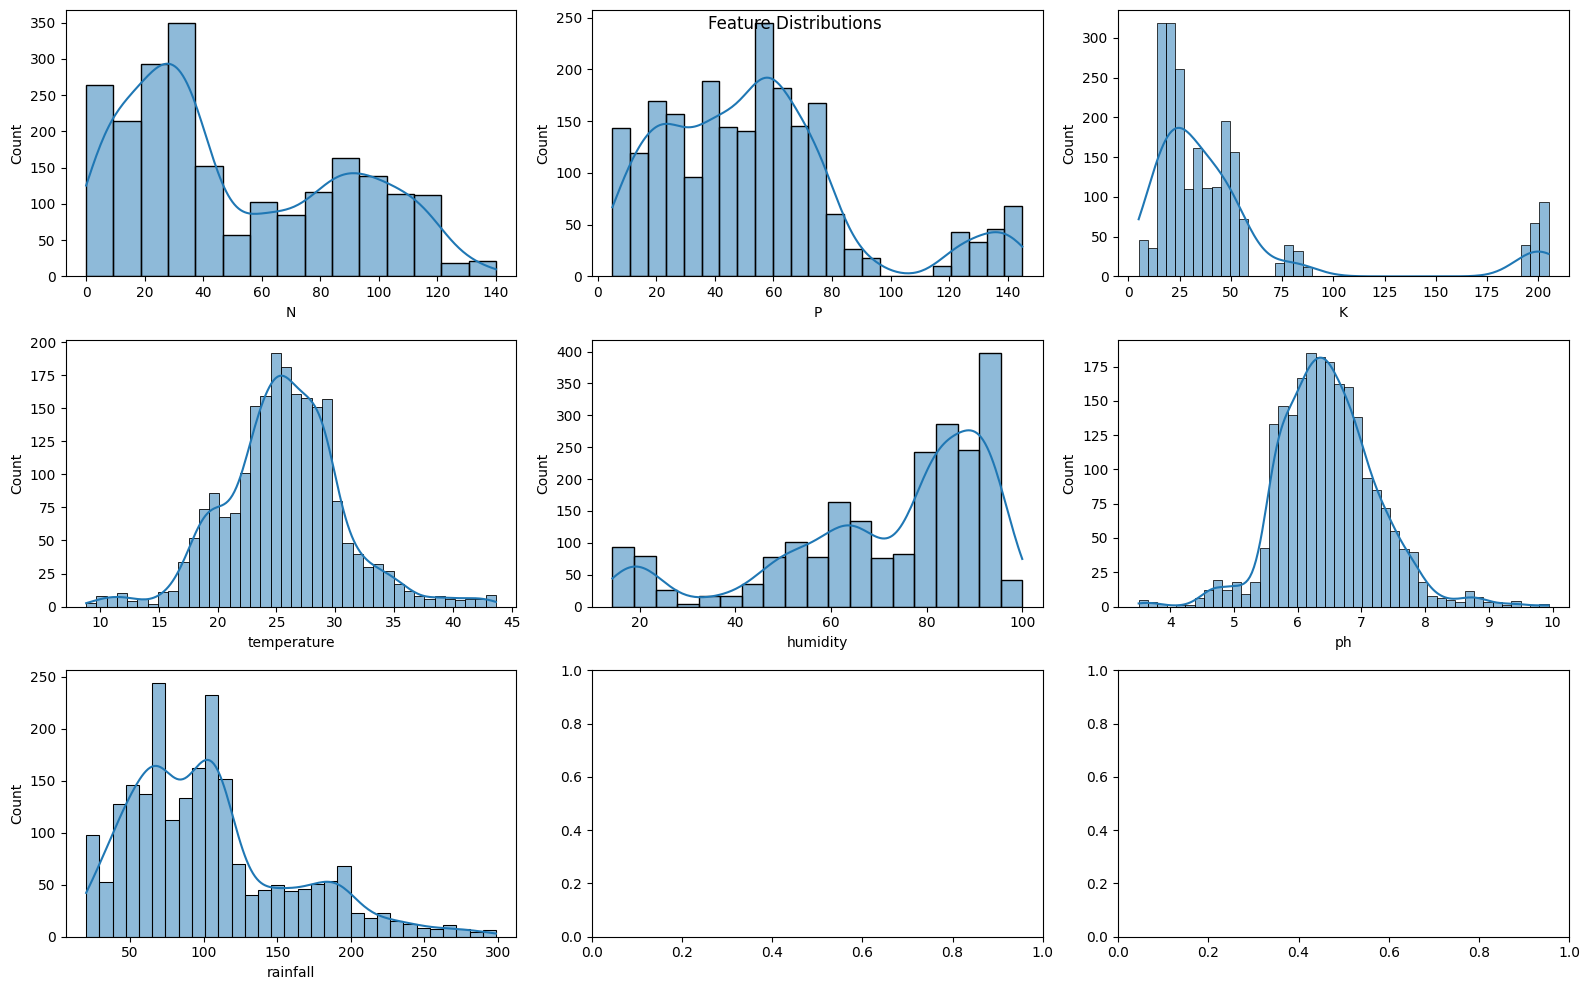

In [146]:
def plot_distributions(data):
    features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    fig, axes = plt.subplots(3, 3, figsize=(16, 10))
    for i, col in enumerate(features):
        sns.histplot(data[col], ax=axes[i//3, i%3], kde=True)
    plt.tight_layout()
    plt.suptitle('Feature Distributions')
    plt.show()

plot_distributions(data)

### Outlier Detection

In [147]:
def detect_outliers_iqr(df, features):
    outliers = {}
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    return outliers

features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
print("Outliers detected per feature:\n", detect_outliers_iqr(data, features))

Outliers detected per feature:
 {'N': 0, 'P': 138, 'K': 200, 'temperature': 86, 'humidity': 30, 'ph': 57, 'rainfall': 100}


### Correlation Matrix

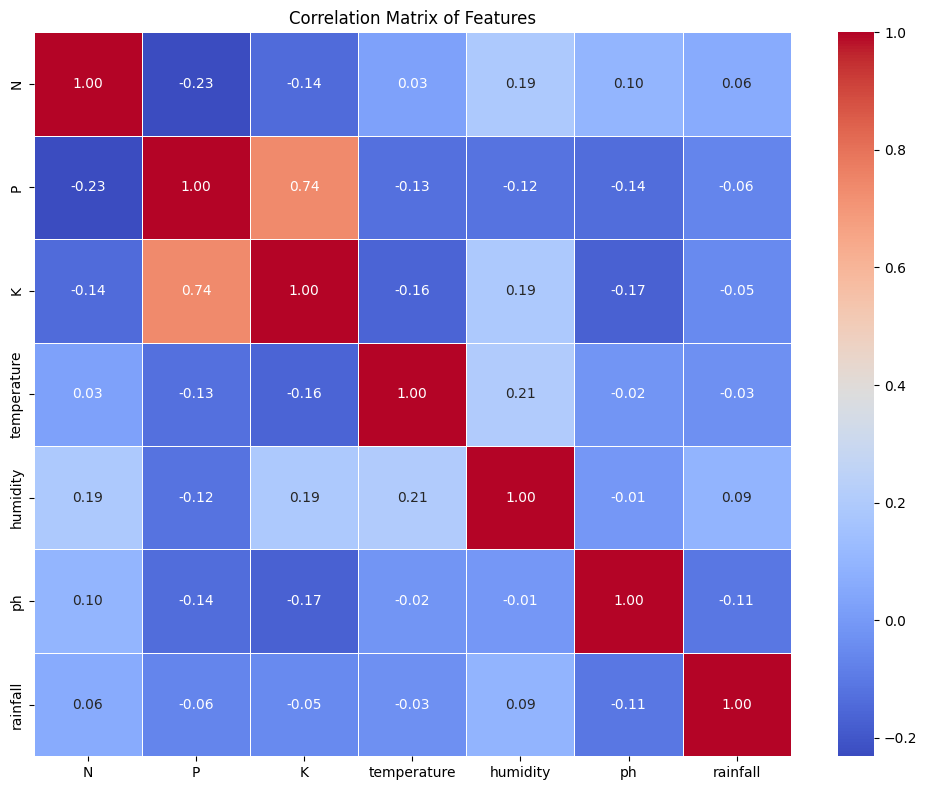

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define features
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

# Ensure all features are numeric
for col in features:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Compute correlation matrix
correlation_matrix = data[features].corr()

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()

### Target Distribution

/tmp/ipython-input-149-2148765965.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='viridis')


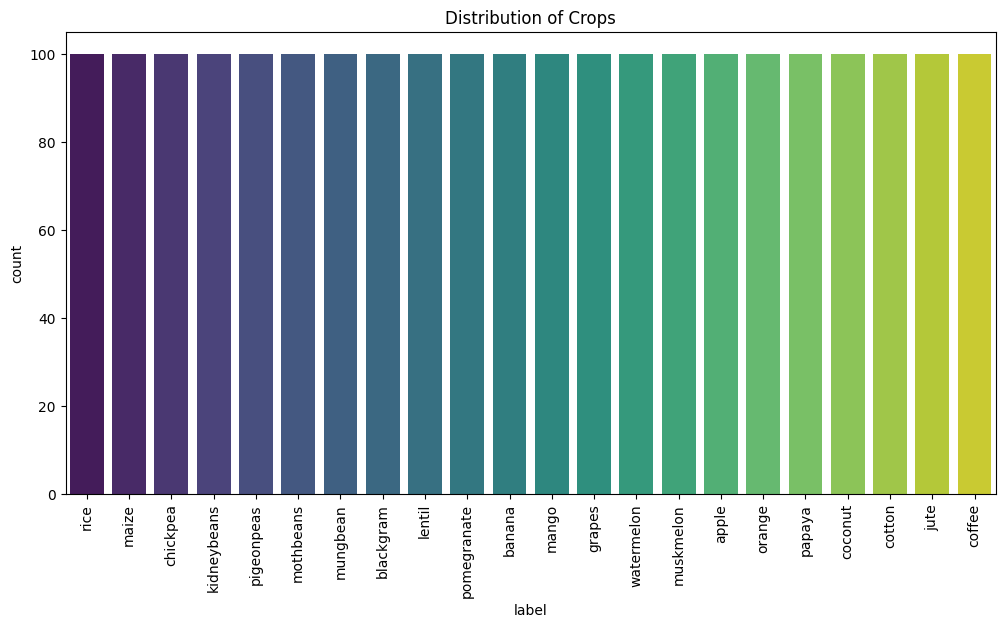

In [149]:
def plot_crop_distribution(data):
    plt.figure(figsize=(12, 6))
    sns.countplot(x='label', data=data, palette='viridis')
    plt.xticks(rotation=90)
    plt.title('Distribution of Crops')
    plt.show()

plot_crop_distribution(data)

### Preprocess Data

In [150]:
# Encoding the labels
def encode_labels(y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return y_encoded, le

X = data.drop('label', axis=1)
y = data['label']

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['label'])

# Save the label encoder
os.makedirs("models", exist_ok=True)
joblib.dump(label_encoder, "models/label_encoder.pkl")

['models/label_encoder.pkl']

### Scale Features

In [151]:
def scale_features(X):
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

X_scaled, scaler = scale_features(X)

### Train-Test Split

In [152]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

### Model Building & Hyperparameter Tuning

#### Random Forest Tuning

In [153]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Instantiate and fit Random Forest search
rf = RandomForestClassifier(random_state=42)
grid_search_rf = RandomizedSearchCV(rf, param_grid_rf, n_iter=10, cv=3, n_jobs=-1, random_state=42)
grid_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]},
                   random_state=42)

In [154]:
from sklearn.ensemble import GradientBoostingClassifier

# Parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5]
}

# Instantiate and fit Gradient Boosting search
gb = GradientBoostingClassifier(random_state=42)
grid_search_gb = RandomizedSearchCV(gb, param_grid_gb, n_iter=10, cv=3, n_jobs=-1, random_state=42)
grid_search_gb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2],
                                        'max_depth': [3, 5],
                                        'n_estimators': [100, 200]},
                   random_state=42)

In [155]:
from sklearn.ensemble import VotingClassifier

# Create the ensemble model
voting_clf = VotingClassifier(
    estimators=[('rf', grid_search_rf.best_estimator_), ('gb', grid_search_gb.best_estimator_)],
    voting='soft'
)

# Train the ensemble
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_leaf=2,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.2,
                                                         n_estimators=200,
                                                         random_state=42))],
                 voting='soft')

### Evaluate Model

In [156]:
def evaluate_model(model, X_test, y_test, label_encoder):
    """Evaluate model performance and visualize confusion matrix."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel Accuracy on Test Set: {accuracy:.2f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Save and Load Artifacts

In [157]:
os.makedirs("models", exist_ok=True)  # Create models folder if not exists
joblib.dump(voting_clf, "models/crop_recommender_ensemble_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
print("\n Model and scaler saved successfully in 'models/' folder.")


 Model and scaler saved successfully in 'models/' folder.


### Recommender Function

In [158]:
def recommend_crop(N, P, K, temperature, humidity, ph, rainfall):
    model = joblib.load("models/crop_recommender_ensemble_model.pkl")
    scaler = joblib.load("models/scaler.pkl")
    label_encoder = joblib.load("models/label_encoder.pkl")

    input_data = np.array([[N, P, K, temperature, humidity, ph, rainfall]])
    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled)
    return label_encoder.inverse_transform(prediction)[0]

# Test
recommended_crop = recommend_crop(50, 20, 29, 25.0, 70.0, 6.5, 80.0)
print(f"Recommended Crop: {recommended_crop}")

Recommended Crop: mango


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
